# A/B–тестирование
Одной из основных задач аналитика является корректное проведение экспериментов. Для этого обычно применяется метод A/B–тестирования.

В данном проекте, входе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Задача: проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# Импорт библиотек
import pandas as pd
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Задаем вид графиков
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# Загрузка данных
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

## Шаг 1. Изучение данных

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
print('Количество строк таблицы "groups" =', len(groups),
      '\nКоличество уникальных значений =', groups.nunique()[0])

Количество строк таблицы "groups" = 74484 
Количество уникальных значений = 74484


In [5]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
print('Количество строк таблицы "active_studs" =', len(active_studs),
      '\nКоличество уникальных значений =', active_studs.nunique()[0])

Количество строк таблицы "active_studs" = 8341 
Количество уникальных значений = 8341


In [7]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [8]:
print('Количество строк таблицы "checks" =', len(checks),
      '\nКоличество уникальных значений =', checks.nunique()[0])

Количество строк таблицы "checks" = 541 
Количество уникальных значений = 541


**Кол-во строк во всех проверяемых таблицах соответствует кол-ву значений по колонке id, - это значит что все значения таблиц уникальны**



## Шаг 2. Объединение таблиц
Для начала нам необходимо объединить информацию из разных таблиц. 

Файл active_studs содержит инфоомацию об id пользователей, которые зашли на платформу в дни проведения эксперимента, в то время как groups - группы, к которым принадлежат эти пользователи. Таблица checks содержит информацию о выручке с пользователя. Создадим новую таблицу, где будет содержаться id пользователя, его группа и чек.

Для этого сначала необходимо переименовать столбец "id" таблицы groups в "student_id" для объединения.

In [9]:
groups.rename(columns={'id': 'student_id'}, inplace=True)

In [10]:
# Объединяем таблицы в единый df
df = active_studs.merge(groups, on='student_id', how='left')
df = df.merge(checks, on='student_id', how='left')
df

,student_id,grp,rev
0,581585,A,NaN
1,5723133,NaN,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


В получившемся датафрейме есть id студентов, которые не попали ни в одну группу. Посмотрим на них отдельно:

In [11]:
df.query('grp.isnull()')

,student_id,grp,rev
1,5723133,NaN,NaN
111,5951797,NaN,NaN
632,5730382,NaN,NaN
2662,5739944,NaN,NaN
3830,5945085,NaN,NaN
4900,5700613,NaN,NaN
5254,5729371,NaN,NaN
5746,5777081,NaN,NaN
7413,5740903,NaN,1900.0
7505,5760471,NaN,NaN


Один из этих студентов совершил оплату в период проведения эксперимента. Однако этот студент не попал в нашу выборку по группам, поэтому можно предположить, что произошла оплата за ранее произведенную покупку. Очистим дф от всех NaN значений:

In [12]:
df.dropna(subset=['grp'], inplace=True)

In [13]:
df

,student_id,grp,rev
0,581585,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
5,5481015,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


## Шаг 3. Разделение на группы
Следующим шагом разделим нашу таблицу на две - разнесем пользователей по группам.

In [14]:
group_a = df.query('grp == "A"')
print('Количество пользователей в контрольной группе:', len(group_a))
group_b = df.query('grp == "B"')
print('Количество пользователей в целевой группе:', len(group_b))

Количество пользователей в контрольной группе: 1535
Количество пользователей в целевой группе: 6793


Как мы видим, в группах присутствует не равное количество пользователей.


## Шаг 4. Сравниваем ключевые метрики
Наша ключевая метрика - выручка. 
Нам также интересно узнать, как изменились следующие метрики:
* ARPU или выручка на пользователя (average revenue per user);
* APPU или выручка на платящего пользователя (average revenue per paying user);
* CR или конверсия в покупку (puchace click-through rate).

In [15]:
# Для начала посчитаем ARPU в обеих группах 
ARPU_a = (group_a.rev.sum() / len(group_a.rev)).round(2)
ARPU_b = (group_b.rev.sum() / len(group_a.rev)).round(2)
print(f'ARPU в контрольной группе составляет {ARPU_a}')
print(f'ARPU в целевой группе составляет {ARPU_b}')
print('\nВ целевой группе эта метрика на', str((ARPU_b*100/ARPU_a - 100).round(2)) + '% больше, чем в контрольной')

ARPU в контрольной группе составляет 47.44
ARPU в целевой группе составляет 256.07

В целевой группе эта метрика на 439.78% больше, чем в контрольной


In [16]:
# ARPPU в обеих группах 
ARPPU_a = group_a.rev.mean().round(2)
ARPPU_b = group_b.rev.mean().round(2)
print(f'ARPPU в контрольной группе составляет {ARPPU_a}')
print(f'ARPPU в целевой группе составляет {ARPPU_b}')
print('\nВ целевой группе эта метрика на', str((ARPPU_b*100/ARPPU_a - 100).round(2)) + '% больше, чем в контрольной')

ARPPU в контрольной группе составляет 933.59
ARPPU в целевой группе составляет 1255.83

В целевой группе эта метрика на 34.52% больше, чем в контрольной


Конверсия = количество посетителей, совершивших целевое действие / общее количество всех посетителей * 100

In [17]:
# CR в обеих группах 
CR_a = round(len(group_a[group_a.rev>0]) / len(group_a.rev) * 100, 2)
CR_b = round(len(group_b[group_b.rev>0]) / len(group_b.rev) * 100, 2)
print(f'CR в контрольной группе составляет {CR_a}%')
print(f'CR в целевой группе составляет {CR_b}%')
print('\nВ целевой группе эта метрика на',  str(round(CR_a - CR_b, 2)) + '% меньше, чем в контрольной')

CR в контрольной группе составляет 5.08%
CR в целевой группе составляет 4.61%

В целевой группе эта метрика на 0.47% меньше, чем в контрольной


Итак, ARPU и ARPPU в целевой группе превышает значение контрольной, однако конверсия в покупку в целевой группе ниже, чем в контрольной. Выясним, действительно ли данные отличаются статистически значимо.

Это можно сделать следующими способами: 
* t-критерий Стьюдента,
* u-критерий Манна Уитни,
* bootstrap.

Для определения наиболее подходящего способа, посмотрим на распределения.

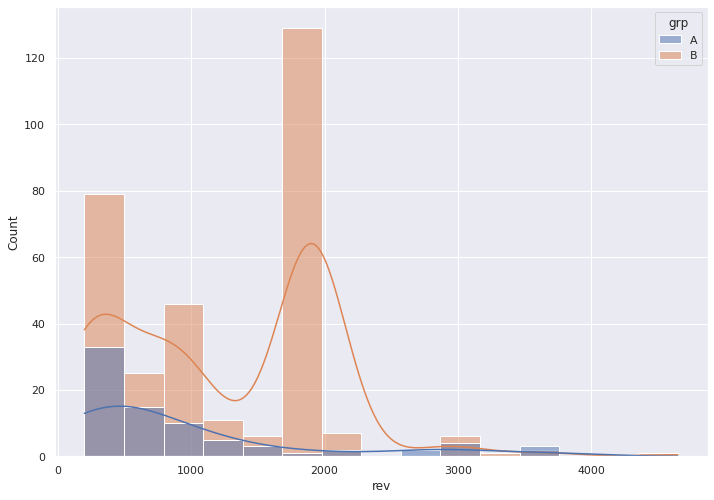

In [18]:
# Посмотрим на распределения выручки по нашим группам
sns.histplot(data=df, x='rev', hue='grp', kde=True, bins=15)

Гистограмма отображает количество платежей (в штуках) по каждой сумме чека. Так как группа B (целевая) содержит в 4 раза больше пользователей, не удивительно, что количество совершенных покупок по каждой сумме выше.

Стоит также обратить внимание на пик в районе 2000: более 100 пользователей группы B произвели покупку на эту сумму, что составляет треть от общего числа юзеров группы, поэтому в нашем случае нельзя применять тест Манна-Уитни, так как критерий Манна-Уитни применим только к мерным данным, т.е. таким, моделью для которых являются непрерывные случайные величины. На практике это означает, что среди анализируемых данных не должно быть совпадающих значений. В нашем случае повторяющихся значений слишком много, поэтому критерий перестает быть свободным от распределения (непараметрическим) и начинает зависеть от неизвестной вероятности совпадений.

Проверим, можем ли мы использовать для критерий Стьюдента.

Критерии применения t-test:
* Данные должны быть нормально распределены.
* Дисперсия данных должна быть одинакова между группами.

Text(0.5, 1.0, 'Целевая группа')

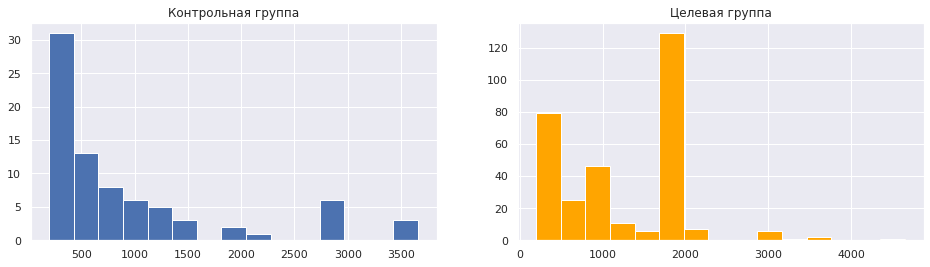

In [19]:
# Теперь посмотрим внимательнее на распределения внутри групп
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
group_a.rev.hist(label='A', bins=15)
plt.title("Контрольная группа")

plt.subplot(1, 2, 2)
group_b.rev.hist(color='orange', bins=15)
plt.title("Целевая группа")

Мы видим, что распределения не близки к нормальным (колоколообразным). Проверим это статистически:

In [20]:
# Проверка на нормальность распределения
def shapiro_check(data):
    if shapiro(data)[1] > 0.05:
        print('Распределение нормально, так как значение \np-value =', shapiro(data)[1])
    else:
        print('Распределение ненормально, так как значение \np-value =', shapiro(data)[1])
        
# Проверка на одинаковость дисперсий
def var_check(group1, group2):
    stat, p = levene(group1, group2)
    if p > 0.05:
        print('Дисперсии выручки контрольной и целевой групп равны')
    else:
        print('Дисперсии выручки контрольной и целевой групп равны')

In [21]:
group_a_without_na = group_a.dropna()
group_b_without_na = group_b.dropna()

In [22]:
# Для контрольной группыгруппы
shapiro_check(group_a_without_na.rev)

Распределение ненормально, так как значение 
p-value = 1.4986822893803264e-10


In [23]:
# Для целевой группыгруппы
shapiro_check(group_b_without_na.rev)

Распределение ненормально, так как значение 
p-value = 1.756778758085431e-16


In [24]:
var_check(group_a_without_na.rev, group_b_without_na.rev)

Дисперсии выручки контрольной и целевой групп равны


Итак, мы не можем применять t-test для проверки, действительно ли данные в наших группах отличаются статистически значимо, так как данные распределены ненормально. Поэтому для проверки будем использовать bootstrap.



## Шаг 5. Определяем нулевую гипотезу и применяем статистические тесты
### Метрика - средняя выручка
Сформулируем нулевую гипотезу (1):

**Нулевая гипотеза - средние выручки в контрольной и целевой группах статистически значимо не отличаются друг от друга**

Нулевую гипотезу принимaют, если наше значение p выше заданного уровня значимости. Мы будем считать различия значимыми при pvalue больше 0,05. 

In [25]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [26]:
x = group_a_without_na.rev
y = group_b_without_na.rev

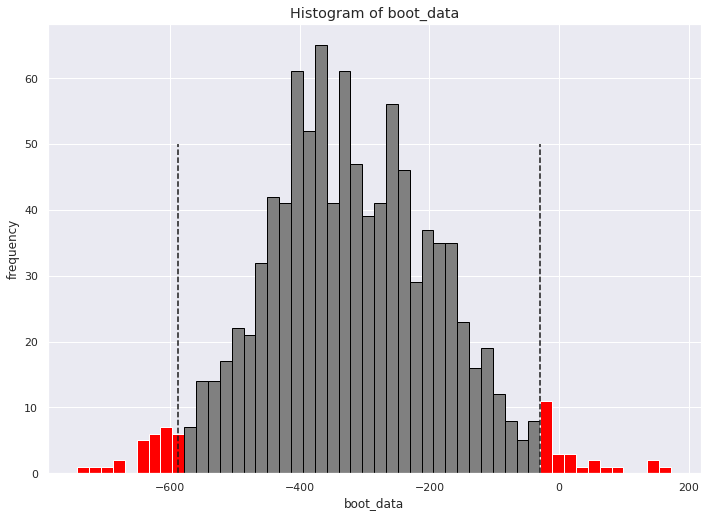

In [27]:
booted_data = get_bootstrap(x, y)  # в результате хранится разница двух распределений, ДИ и pvalue

In [28]:
print('p-value =', round(booted_data["p_value"], 5))

p-value = 0.0205


In [29]:
booted_data["quants"] # Доверительный интервал

,0
0.025,-587.676940
0.975,-29.817638


В нашем случае, бутстрап считает разницу между средними бутстрапированных выборок. Если бы разница между проверяемыми значениями отсутствовала, то разность между средними была бы равной нулю (попала в интервал, который включает в себя 0). Однако наш результат не включает ноль. 95% доверительный интервал лежит в промежутке ~от -586 до -52, cледовательно выручка в контрольной и целевой группах стат-значимо **отличаются**.

### Проверим также вторую метрику - конверсию в покупку

Сформулируем нулевую гипотезу (2):

**Нулевая гипотеза - конверсия в покупку в контрольной и целевой группах статистически значимо не отличаются друг от друга**

Поскольку мы проводим A/B-тест для конверсий (конверсия представляет собой категориальную переменную, так как пользовательлибо совершил покупку (1) либо нет совершил покупку (0)), мы будем использовать критерий **хи-квадрат**.

In [30]:
print('Количество платящих пользователей контрольной группы:', len(group_a[group_a.rev>0]), '\nКоличество неплатящих пользователей контрольной группы', len(group_a[group_a.rev.isna()]))
print('\n\nКоличество платящих пользователей целевой группы:', len(group_b[group_b.rev>0]), '\nКоличество неплатящих пользователей целевой группы', len(group_b[group_b.rev.isna()]))

Количество платящих пользователей контрольной группы: 78 
Количество неплатящих пользователей контрольной группы 1457


Количество платящих пользователей целевой группы: 313 
Количество неплатящих пользователей целевой группы 6480


In [31]:
groups_CR = [[len(group_a[group_a.rev>0]), len(group_a[group_a.rev.isna()])], [len(group_b[group_b.rev>0]), len(group_b[group_b.rev.isna()])]]
xi, p_value, dof, expected = stats.chi2_contingency(groups_CR)
print(f"Хи-квадрат: {xi.round(3)}\np-value: {p_value.round(3)}\nКоличество степеней свободы: {dof}")

Хи-квадрат: 0.527
p-value: 0.468
Количество степеней свободы: 1


Значение p-value значительно превышает 0,05, cледовательно, мы не можем отклонить нулевую гипотезу и можем прийти к заключению, что конверсия в покупку в контрольной и целевой группах стат-значимо **не отличаются**.

## Шаг 6. Делаем вывод

*Выручка* в контрольной и целевой группах стат-значимо **отличается** при том, что *конверсия в покупку* стат.значимо не изменилась. Рекомендуется **запускать новую механику** на всех пользователей.

|

|

|

# Что если наш эксперимент продолжается и нам нужно отслеживать метрики постоянно, добавляя новые данные?

Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [32]:
def check_p(pvalue):
    """
    Функция принимает в качестве аргумента значение уровня значимости статистического теста.
    Функция используется для проверки статистической значимости результата теста.
    """
    if pvalue > 0.05:
        return 'Принимаем нулевую гипотезу'
    else:
        return 'Отклоняем нулевую гипотезу'
    

def summary(pvalue1, pvalue2):
    """
    Функция принимает на вход два значения p-value
    и на основе их значений формулирует вывод о результате A/B-тестирования.
    """
    if pvalue1 < 0.05 and pvalue2 > 0.05:
        return '\n\nВывод: выручка в контрольной и целевой группах стат-значимо отличаются, а конверсия в покупку - нет. Рекомендуется запускать новую механику на всех пользователей.'
    elif pvalue1 > 0.05 and pvalue2 > 0.05:
        return '\n\nВывод: выручка в контрольной и целевой группах стат-значимо НЕ отличаются, как и конверсия в покупку. Запускать новую механику не имеет практического смысла.'
    elif pvalue1 > 0.05 and pvalue2 < 0.05:
        return '\n\nВывод: выручка в контрольной и целевой группах стат-значимо НЕ отличаются, а конверсия в покупку изменилась. Не рекомендуется запускать новую механику на всех пользователей.'
    else:
        return '\n\nВывод: выручка в контрольной и целевой группах стат-значимо отличаются, как и конверсия в покупку. Рекомендуется проводить более детальное исследование'

In [33]:
def add_new_file(file_name):
    """
    Функция считывает данные из CSV-файла с данными о группах,
    производит анализ A/B-теста для контрольной и целевой групп. 
    Она вычисляет несколько метрик (ARPU, ARPPU, CR) и использует
    bootstrap для вычисления p-value.
    
    Аргументы:
    file_name -- имя csv-файла, из которого нужно считать данные о группах
    
    Возвращаемое значение:
    Вывод AB-теста, результаты анализа.
    """
    groups_add   = pd.read_csv(file_name, sep=',')
    groups_add.rename(columns={'id': 'student_id'}, inplace=True)
    add_df = groups_add.merge(checks, on='student_id', how='inner')
    add_df = df.merge(add_df, on=['student_id', 'grp', 'rev'], how='outer')
    add_group_a = add_df.query('grp == "A"')
    add_group_b = add_df.query('grp == "B"')
    
    # Для начала посчитаем ARPU в обеих группах 
    ARPU_a = (group_a.rev.sum() / len(group_a.rev)).round(2)
    ARPU_b = (group_b.rev.sum() / len(group_a.rev)).round(2)
    print(f'ARPU в контрольной группе составляет {ARPU_a}')
    print(f'ARPU в целевой группе составляет {ARPU_b}')
    print('В целевой группе эта метрика на', str((ARPU_b*100/ARPU_a - 100).round(2)) + '% больше, чем в контрольной')
    
    # ARPPU в обеих группах 
    ARPPU_a = group_a.rev.mean().round(2)
    ARPPU_b = group_b.rev.mean().round(2)
    print(f'ARPPU в контрольной группе составляет {ARPPU_a}')
    print(f'ARPPU в целевой группе составляет {ARPPU_b}')
    print('\nВ целевой группе эта метрика на', str((ARPPU_b*100/ARPPU_a - 100).round(2)) + '% больше, чем в контрольной')

    # CR в обеих группах 
    CR_a = round(len(group_a[group_a.rev>0]) / len(group_a.rev) * 100, 2)
    CR_b = round(len(group_b[group_b.rev>0]) / len(group_b.rev) * 100, 2)
    print(f'CR в контрольной группе составляет {CR_a}%')
    print(f'CR в целевой группе составляет {CR_b}%')
    print('\nВ целевой группе эта метрика на',  str(round(CR_a - CR_b, 2)) + '% меньше, чем в контрольной')
    
    # bootstrap (выручка)
    add_group_a_without_na = add_group_a.dropna()
    add_group_b_without_na = add_group_b.dropna()
    x = add_group_a_without_na.rev
    y = add_group_b_without_na.rev
    booted_data = get_bootstrap(x, y)
    print('\np-value при сравнении групп по выручке:', round(booted_data["p_value"], 5))
    print(check_p(booted_data["p_value"]))
    
    # хи-квадрат (конверсия в покупку)
    groups_CR = [[len(group_a[group_a.rev>0]), len(group_a[group_a.rev.isna()])], [len(group_b[group_b.rev>0]), len(group_b[group_b.rev.isna()])]]
    xi, p, dof, expected = stats.chi2_contingency(groups_CR)
    print(f"\np-value при сравнении групп по конверсии: {p_value.round(5)}")
    print(check_p(p_value))
    
    # summarize
    print(summary(booted_data["p_value"], p_value))

ARPU в контрольной группе составляет 47.44
ARPU в целевой группе составляет 256.07
В целевой группе эта метрика на 439.78% больше, чем в контрольной
ARPPU в контрольной группе составляет 933.59
ARPPU в целевой группе составляет 1255.83

В целевой группе эта метрика на 34.52% больше, чем в контрольной
CR в контрольной группе составляет 5.08%
CR в целевой группе составляет 4.61%

В целевой группе эта метрика на 0.47% меньше, чем в контрольной


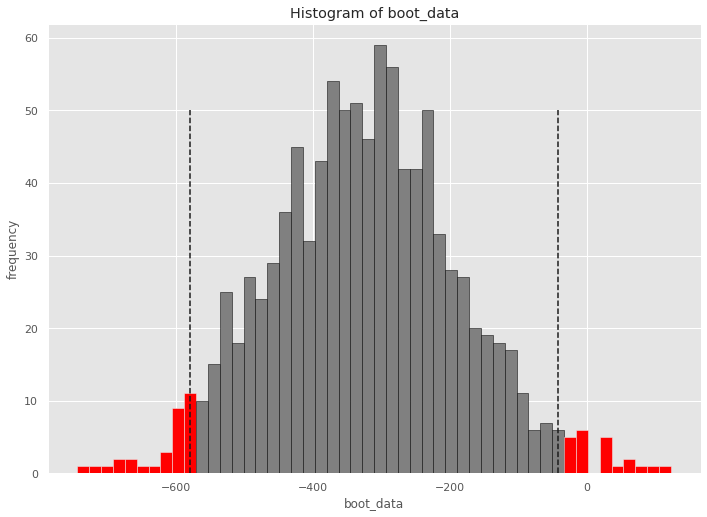


p-value при сравнении групп по выручке: 0.01701
Отклоняем нулевую гипотезу

p-value при сравнении групп по конверсии: 0.46804
Принимаем нулевую гипотезу


Вывод: выручка в контрольной и целевой группах стат-значимо отличаются, а конверсия в покупку - нет. Рекомендуется запускать новую механику на всех пользователей.


In [34]:
add_new_file('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')